In [1]:
# Useful bits
import re
import json
import os.path
import pandas as pd
import numpy as np

# Interactive Computing
from IPython.display import display
import time
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
all_levels = pd.read_pickle('all_levels.pkl')
all_levels['text'] = all_levels['text'].str.replace(r'\s+', r' ', regex=True)
all_levels

,id,lvl,unit,author_id,author_nationality,topic,topic_id,date,grade,text
0,C18217,1,7,20967052,cn,Writing labels for a clothing store,22440,2012-04-20 21:12:14.890,79,Date:monday 11th. Time:9.30 am. From:Margaret...
1,C18541,1,1,21016113,cn,Introducing yourself by email,3535,2011-12-24 03:50:49.100,85,"Dear teacher, My name's Yi Zhao,English is po..."
2,C18648,1,1,20967075,cn,Introducing yourself by email,3535,2012-04-20 08:53:55.087,90,"My name's Henry Hong, I was born in Nanjing o..."
3,C20184,1,1,18898793,cn,Introducing yourself by email,3535,2011-12-14 08:54:48.380,95,"Dear Sir, I'm Jianwen Zhang, from a little to..."
4,C20185,1,2,18898793,cn,Taking inventory in the office,9820,2011-12-26 09:49:48.140,98,"Dear Ms Thomas, There are thirteen computers ..."
...,...,...,...,...,...,...,...,...,...,...
549276,U718945,16,2,21649452,us,Writing about a symbol of your country,8341,2012-09-04 02:47:23.180,65,THE SPACE NEEDLE The United States's Northwes...
549277,U719493,16,1,24750663,ae,Attending a robotics conference,7524,2012-09-05 20:41:18.933,0,This is a most new matter of proto and Robots...
549278,U722572,16,5,22117882,br,Using creative writing techniques,9146,2012-09-17 20:59:34.413,96,"Hi Tabby, Never mind about asking me such a f..."
549279,U724086,16,2,19328467,sa,Writing about a symbol of your country,8341,2012-09-23 06:55:59.733,94,Oil Tower Statue It is a statue of transition...


In [115]:
from scipy import stats


intermediate_df = all_levels.copy()
print(intermediate_df.shape)
intermediate_df['grade'] = pd.to_numeric(intermediate_df['grade'].astype(str), errors='coerce').fillna(0).astype(int)
# intermediate_df.drop(intermediate_df[intermediate_df['grade'] < 1 ].index , inplace=True)

for i in range(7):
    intermediate_df.drop(intermediate_df[(np.abs(stats.zscore(intermediate_df['grade'])) >= 2.5)].index , inplace=True)
    print(intermediate_df.shape)
    
learner_avg_grade = intermediate_df.groupby('author_id').grade.transform(np.mean).rename('learner_avg_grade')
df = pd.concat([intermediate_df, learner_avg_grade], axis=1)



(549281, 10)
(531180, 10)
(522900, 10)
(516049, 10)
(515370, 10)
(514313, 10)
(514313, 10)
(514313, 10)


Table 1

Descriptive statistics to include M, SD, Median, Mode, Min, Max, Range

In [116]:
descriptives = pd.DataFrame([(df.learner_avg_grade.mean(),
                              df.learner_avg_grade.median(),
                              df.learner_avg_grade.mode()[0],
                              df.learner_avg_grade.min(),
                              df.learner_avg_grade.max(),
                              df.learner_avg_grade.max() - df.learner_avg_grade.min())],
                              columns=('mean',
                                       'median',
                                       'mode',
                                       'minimum',
                                       'maximum',
                                       'range'))

display(descriptives)
print(descriptives.round(2).to_latex(index=False))  

,mean,median,mode,minimum,maximum,range
0,91.538583,91.75,90.0,75.0,100.0,25.0


\begin{tabular}{rrrrrr}
\toprule
 mean &  median &  mode &  minimum &  maximum &  range \\
\midrule
91.54 &   91.75 &  90.0 &     75.0 &    100.0 &   25.0 \\
\bottomrule
\end{tabular}



Table 2

Skewness and kurtosis

In [108]:
table2 = pd.DataFrame([(df.learner_avg_grade.skew(),
                              df.learner_avg_grade.kurtosis())],
                              columns=('skew',
                                       'kurtosis'))

display(table2)
print(table2.round(2).to_latex(index=False))  

,skew,kurtosis
0,-0.641529,1.638163


\begin{tabular}{rr}
\toprule
 skew &  kurtosis \\
\midrule
-0.64 &      1.64 \\
\bottomrule
\end{tabular}



Table 3

Tests of normality

In [109]:
from numpy.random import seed
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(df.learner_avg_grade)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
table3 = pd.DataFrame([(shapiro(df.learner_avg_grade)),
                       (kstest(df.learner_avg_grade, 'norm'))],
                        index = ('Shapiro',
                                'Kolmogorov-Smirnov'),
                        columns=('Statistic',
                                 'Sig.'))

display(table3)
print(table3.round(2).to_latex(index=True))  

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)


/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Statistic,Sig.
Shapiro,0.977128,0.0
Kolmogorov-Smirnov,1.000000,0.0


\begin{tabular}{lrr}
\toprule
{} &  Statistic &  Sig. \\
\midrule
Shapiro            &       0.98 &   0.0 \\
Kolmogorov-Smirnov &       1.00 &   0.0 \\
\bottomrule
\end{tabular}



Figure 1

Histogram

<AxesSubplot:xlabel='learner_avg_grade', ylabel='Count'>

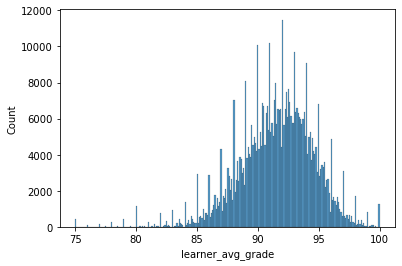

In [110]:
sns.histplot(data=df, x="learner_avg_grade")

Figure 2

Q-Q plots

In [112]:
df.to_csv("learner_avg_grade_for_descriptive_statistcs.csv")

Figure 3

Box plots

<AxesSubplot:xlabel='author_id', ylabel='Count'>

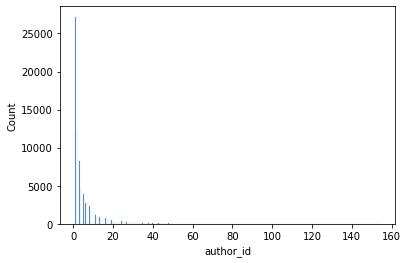

In [120]:
sns.histplot(df.author_id.value_counts())